## Renzo Polo

...

## Importamos librerías

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

#from deap import algorithms
from deap import base  # Estructura que permite agrupar todos los componentes de nuestro algoritmo en una misma bolsa
from deap import creator  # Permite crear los componentes de nuestro algoritmo
from deap import tools  # Contiene funciones precargadas

from joblib import Parallel, delayed

<div style='background:#A2FFF2; padding:10px;'>
<h1>Enunciado</h1>
Se desea encontrar el mínimo de la función que se presenta en la celda siguiente, dentro del intervalo [$-500$,$500$].
    
Proponga un algoritmo genético capaz de resolver esta tarea.
</div>

In [2]:
def F(x,y):
    '''
    Función a optimizar.
    '''
    z = 418.9829 * 2 - x * np.sin( np.sqrt( np.abs( x )))- y * np.sin( np.sqrt(np.abs(y)))

    return z

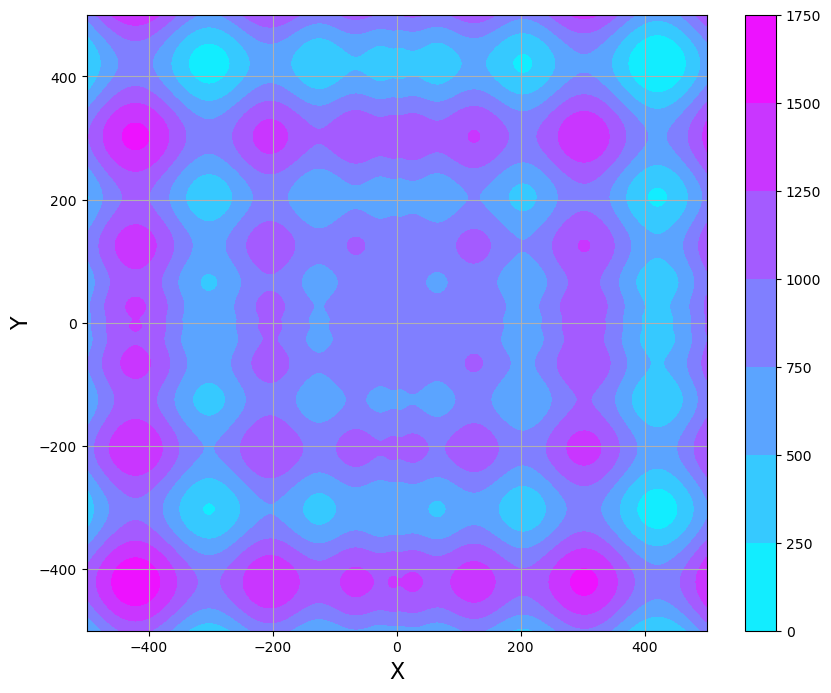

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

V = np.arange(-500, 500.1, 0.1)

X,Y  = np.meshgrid(V, V)

Z = F(X,Y)

# GRAFICAMOS SUPERFICIE
cs = ax.contourf(X,Y,Z, cmap='cool')

ax.grid(True)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)

fig.colorbar(cs)
plt.show()

---

## Funciones auxiliares

In [4]:
#=================================
def bin(p=0.5):
    '''
    Esta función genera un bit al azar.
    '''
    if random.random() < p:
        return 1
    else:
        return 0
#=================================


#=================================
def mutation(ind, p):
    '''
    Esta función recorre el cromosoma y evalúa, para cada gen,
    si debe aplicar el operador de mutación.
    '''
    
    return [abs(i-1) if random.random() < p else i for i in ind]
#=================================

**CONSIGNA 1**: Implemente una función para realizar el mapeo del genotipo al fenotipo.

In [7]:
def bin2dec(ind, low, high):
    '''
    Esta función divide la representación original en 2 listas x e y, 
    luego las convierte en valores decimales, dados
    los límites inferior y superior tomados para la
    conversión.
    low: Límite inferior del rango a barrer
    high: Límite superior del rango a barrer
    '''
    N = len(ind)  # Número binario. Los primeros 10 valores corresponden a la coordenada X y los 10 finales a la coordenada Y [vector de 0's y 1's]
    medio = N//2
    
    bin_x = ind[:medio]
    bin_y = ind[medio:]

    x = 0
    y = 0

    
    for k,i in enumerate(bin_x[::-1]):
        x += (i * 2**k)

    x = low + ((high-low)/ (2**medio)) * x

    for k,i in enumerate(bin_y[::-1]):
        y += (i * 2**k)

    y = low + ((high-low)/ (2**medio)) * y

    return x, y

**CONSIGNA 2**: Implemente la función de fitness para guiar la optimización.

In [20]:
def fitness(ind, low, high):
    '''
    Función de aptitud empleada por nuestro algoritmo.
    '''
    
    dec = bin2dec(ind, low=low, high=high)
    
    z = F(dec[0], dec[1])
    
    return z

## Inicializamos parámetros del experimento

**CONSIGNA 3**: Proponga valores para los siguientes parámetros:
- `IND_SIZE`   # Cantidad total de genes en el cromosoma
- `LB`         # Límite inferior del rango a evaluar
- `UB`         # Límite superior del rango a evaluar
- `POP_SIZE`   # Cantidad de individuos en la población
- `PM`         # Probabilidad de mutación
- `N_PARENTS`  # Número de padres para la cruza
- `PX`         # Probabilidad de cruza
- `GMAX`       # Cantidad máxima de generaciones

Justifique su elección.

In [111]:
IND_SIZE = 20  # Cantidad total de genes en el cromosoma
LB = -512        # Límite inferior del rango a evaluar
UB = 512        # Límite superior del rango a evaluar

POP_SIZE = 100  # Cantidad de individuos en la población
PM = 1./IND_SIZE        # Probabilidad de mutación [aproximadamente 1 gen por cromosoma]
N_PARENTS = POP_SIZE - 1 # Número de padres seleccionados para generar la descendencia
PX = 0.9        # Probabilidad de cruza
GMAX = 100      # Cantidad máxima de generaciones que se ejecutará el algoritmo

Como el intervalo de búsqueda planteado es `[-500,500]` se genera un cromosoma de 20 bits de los cuales los primeros 10 bits (1024 valores) corresponden a las coordenadas X y los últimos 10 bits a la coordenada Y. La lista es dividida a la mitad para representar ambas coordenadas y luego transformada a decimal (funcion bin2dec).
La probabilidad de mutación es de 1 gen para realizar pequeños cambios en los cromosomas.
Se prueban en una primera instancia con una población de 100 individuos generaciones y 100 generaciones.
Se realiza una sustitución completa de la población de generacion a generacion (99 padres).

## Creamos los componentes del algoritmo

In [112]:
# CREAMOS LA FUNCION DE FITNESS
# Esta función tiene "1 OBJETIVO" a "MINIMIZAR"
creator.create("Fitness",  # Nombre con el que se registra el componente
               base.Fitness,  # Clase de la que hereda
               weights=(-1.0,)) # Minimización de la función

#---------------------

# CREAMOS EL CONSTRUCTOR DE INDIVIDUOS
creator.create("Individual", # Nombre con el que se registra el componente
               list,  # Clase de la que hereda [Tipo de contenedor en este caso]
               fitness=creator.Fitness)  # Asignamos un método para evaluar el fitness del individuo

## REGISTRAMOS COMPONENTES

In [113]:
toolbox = base.Toolbox()

#---------------------

# DEFINIMOS COMO CONSTRUIR UN GEN
toolbox.register("attribute",  # Nombre con el que se registra el componente
                 bin,
                 p=0.5)  # Función asociada a ese componente

#---------------------

# DEFINIMOS COMO CONSTRUIR UN INDIVIDUO/CROMOSOMA
toolbox.register("individual",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 creator.Individual,  # ...
                 toolbox.attribute,  # Función para construir cada gen
                 n=IND_SIZE)  # Número de genes del cromosoma/individuo (se repetirá la función construir gen)

#---------------------

# DEFINIMOS COMO CONSTRUIR LA POBLACION
toolbox.register("population",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 list,
                 toolbox.individual)

#---------------------

# DEFINIMOS COMO REALIZAR LA CRUZA
toolbox.register("mate",  # Nombre con el que se registra el componente
                 tools.cxTwoPoint)  # 

#---------------------

# DEFINIMOS COMO REALIZAR LA MUTACION
toolbox.register("mutate",  # Nombre con el que se registra el componente
                 mutation,  # Método de mutación (definido como función más arriba)
                 p=PM)  # Parámetro que usa la mutación

#---------------------

# DEFINIMOS COMO REALIZAR LA SELECCION DE INDIVIDUOS
toolbox.register("select",  # Nombre con el que se registra el componente
                 tools.selTournament,  # Método usado para selección [selRoulette | selTournament | ...]
                 tournsize=5)  # Parámetro que usa el torneo

## Definimos las estadísticas a calcular

In [114]:
# EXTRAEMOS EL FITNESS DE TODOS LOS INDIVIDUOS
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)

# EXTRAEMOS EL TAMAÑO DE TODOS LOS INDIVIDUOS
stats_size = tools.Statistics(key=len)

# EXTRAEMOS EL TAMAÑO DE TODOS LOS INDIVIDUOS
stats_active_genes = tools.Statistics(key=lambda ind: np.sum(ind))

mstats = tools.MultiStatistics(fitness=stats_fit,
                               size=stats_size,
                               genes=stats_active_genes)

mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# INICIALIZAMOS UN LOGGER
logbook = tools.Logbook()

In [115]:
#================================================
# INICIALIZAMOS LA POBLACIÓN
#================================================
pop = toolbox.population(n=POP_SIZE)  # Inicializamos una población
#================================================

In [116]:
pop[0]

[1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]

In [117]:
#================================================
# EVALUAMOS EL FITNESS DE LA POBLACION
#======================================
fitnesses = Parallel(n_jobs=6, backend='multiprocessing')(delayed(fitness)(ind, LB, UB) for ind in pop)
#================================================

#================================================
# ASIGNAMOS A CADA INDIVIDUO SU FITNESS
#========================================
for ind,fit in zip(pop, fitnesses):
    ind.fitness.values = (fit,)  # Guardamos el fitness para cada individuo (en el individuo)
#================================================

records = mstats.compile(pop)
logbook.record(gen=0, **records)

In [118]:
pop[0].fitness.values

(474.09695676953083,)

**CONSIGNA 4**: Proponga el ciclo de pasos a seguir por el algoritmo para realizar la evoluión.

In [119]:
#################################################################################
# COMENZAMOS LA EVOLUCION
################################

for g in range(1,GMAX):

    #================================================
    # SELECCIONAMOS INDIVIDUO ELITE
    #================================
    idx_elite = np.argmin(fitnesses)  # Si maximizamos, hay que usar ".argmax()"
    elite = toolbox.clone(pop[idx_elite])
    del elite.fitness.values
    #================================================

    
    #================================================
    # HACEMOS UNA COPIA DE LA POBLACION ACTUAL
    #==========================================
    parents = toolbox.select(pop, POP_SIZE)  # Seleccionamos individuos para alcanzar
                                               # el tamaño de la población
    
    offspring = list(map(toolbox.clone, pop))  # Clonamos para tener nuevos individuos
                                                     # (contenedores independientes)
    #================================================


    #================================================
    # REALIZAMOS LA CRUZA DE LOS PADRES
    #====================================
    for i in range(POP_SIZE//2):
        parent1 = toolbox.clone(parents[random.randint(0,POP_SIZE-1)])
        parent2 = toolbox.clone(parents[random.randint(0,POP_SIZE-1)])
        
        if random.random() < PX:
            childs = toolbox.mate(parent1, parent2)
        else:
            childs = (parent1, parent2)
        
        offspring[2*i] = childs[0]
        offspring[2*i+1] = childs[1]
    #================================================


    #================================================
    # MUTAMOS LOS HIJOS
    #=================================
    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
    #================================================
    
    
    #================================================
    # EVALUAMOS EL FITNESS
    # Y SE LO ASIGNAMOS A CADA INDIVIDUO
    #======================================
    offspring[0] = elite

    fitnesses = Parallel(n_jobs=6, backend='multiprocessing')(delayed(fitness)(ind, LB, UB) for ind in offspring)
    
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = (fit,)
    #================================================

    
    #================================================
    # CONSTRUIMOS LA NUEVA POBLACION
    #================================
    pop = toolbox.clone(offspring)
    #================================================
    
    #================================================
    # CALCULAMOS ESTADÏSTICAS
    #============================
    records = mstats.compile(pop)
    logbook.record(gen=g, **records)

    if (g%10 == 0):
        print('='*79)
        print(f'GENERATION: {g}')
        print(f'ELITE -- Fitness: {elite.fitness.values[0]:.4}')
        print('FITNES: ', records['fitness'])
    #================================================

GENERATION: 10
ELITE -- Fitness: 3.196
FITNES:  {'avg': 3.388817948180845, 'std': 0.8690639172566755, 'min': 3.1964265275792627, 'max': 11.334159134949289}
GENERATION: 20
ELITE -- Fitness: 3.196
FITNES:  {'avg': 3.1964265275792627, 'std': 0.0, 'min': 3.1964265275792627, 'max': 3.1964265275792627}
GENERATION: 30
ELITE -- Fitness: 3.196
FITNES:  {'avg': 3.1964265275792627, 'std': 0.0, 'min': 3.1964265275792627, 'max': 3.1964265275792627}
GENERATION: 40
ELITE -- Fitness: 3.196
FITNES:  {'avg': 3.1964265275792627, 'std': 0.0, 'min': 3.1964265275792627, 'max': 3.1964265275792627}
GENERATION: 50
ELITE -- Fitness: 3.196
FITNES:  {'avg': 3.1964265275792627, 'std': 0.0, 'min': 3.1964265275792627, 'max': 3.1964265275792627}
GENERATION: 60
ELITE -- Fitness: 3.196
FITNES:  {'avg': 3.1964265275792627, 'std': 0.0, 'min': 3.1964265275792627, 'max': 3.1964265275792627}
GENERATION: 70
ELITE -- Fitness: 3.196
FITNES:  {'avg': 3.1964265275792627, 'std': 0.0, 'min': 3.1964265275792627, 'max': 3.1964265275

## Graficamos la evolución del fitness

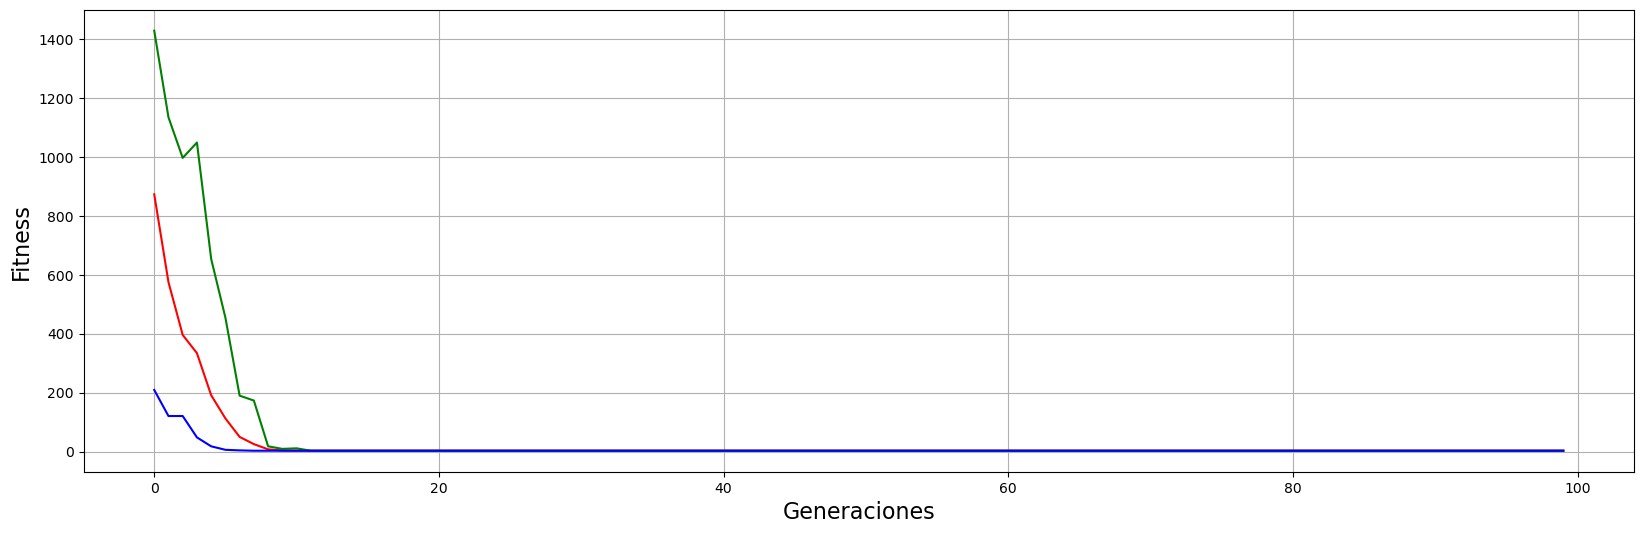

In [120]:
f_avg = [f['avg'] for f in logbook.chapters['fitness']]  # Extraemos fitness promedio a lo largo de las épocas
f_max = [f['max'] for f in logbook.chapters['fitness']]  # Extraemos fitness máximo a lo largo de las épocas
f_min = [f['min'] for f in logbook.chapters['fitness']]  # Extraemos fitness mínimo (elite) a lo largo de las épocas

fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(GMAX), f_avg, '-r')
ax.plot(range(GMAX), f_max, '-g')
ax.plot(range(GMAX), f_min, '-b')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Fitness', fontsize=16)
ax.grid(True)

**CONSIGNA 5**: ¿Qué puede concluir de estas curvas de evolución?

Se bien hay algunos parametros para ajustar, las curvas de evolución presentan una convergencia en el valor minimo en aproximadamente 10 epocas.

**CONSIGNA 6**: ¿Cuáles son las coordenadas del mejor individuo?

In [121]:
x_elit = bin2dec(pop[0],LB,UB)[0]
y_elit = bin2dec(pop[0],LB,UB)[1]
print('X Elite:', x_elit)
print('Y Elite:', y_elit)

X Elite: 421.0
Y Elite: 426.0


## Graficamos la solución

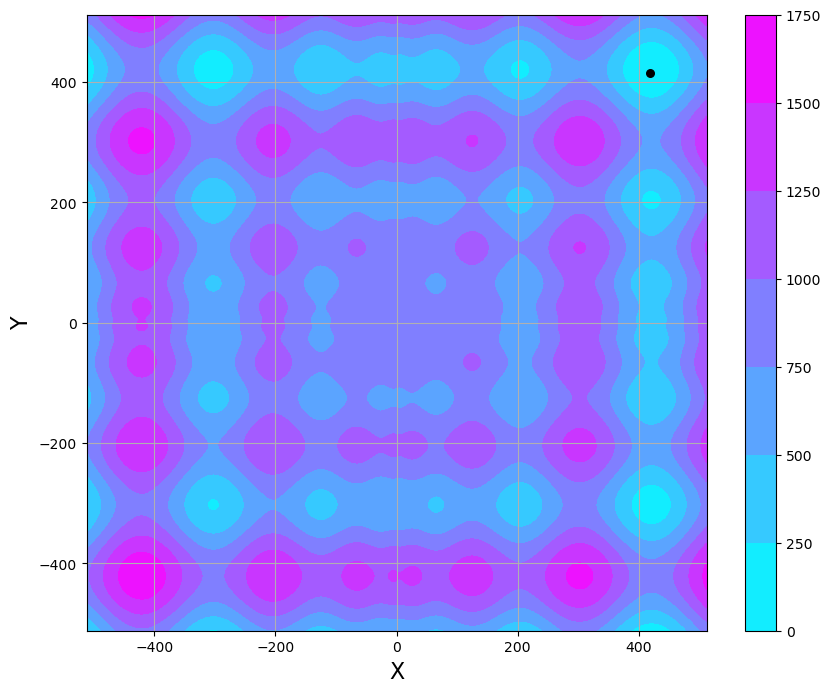

In [87]:
#====================================================
# PLOT RESULTS
#===================
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

delta = 0.1
V = np.arange(LB, UB+delta, delta)

X,Y  = np.meshgrid(V, V)

Z = F(X,Y)

# GRAFICAMOS SUPERFICIE
cs = ax.contourf(X,Y,Z, cmap='cool')

ax.scatter(x_elit, y_elit, s=30, c='k')

ax.grid(True)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)

fig.colorbar(cs)
plt.show()

**CONSIGNA 7**: ¿Cómo modificaría la función de mapeo de genotipo a fenotipo para que sea capaz de representar con diferente resolución los valores de `x` e `y`? Por ejemplo, `x` usando 8 bits e `y` usando 16 bits.

La funcion de mapeo implementada solamente requiere cambiar IND_SIZE al valor de resolución requerido multiplicado por 2. Es decir 2*Resolucion = IND_SIZE

**CONSIGNA 8**: Ejecute el algoritmo 5 veces, empleando en cada caso 8 y 32 bits para representar cada variable. Construya una tabla con las coordenadas obtenidas en cada caso. ¿Se conserva la solución? Comente al respecto.

In [ ]:
Se modificó el parámetro IND_SIZE = 2*Resolucion y se ejecutó el algoritmo dando los siguientes resultados:

Con resolución 10 bits:
X Elite: 421.0
Y Elite: 426.0

Con resolución 16 bits:
X Elite: 421.03125
Y Elite: 421.015625

Con resolución 8 bits:
X Elite: 420.0
Y Elite: 420.0
